# BLU11 - Learning Notebook - Part 1 of 2 - Collaborative Filtering

In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from numpy.linalg import norm
from scipy.sparse import csr_matrix, save_npz

from sklearn.metrics.pairwise import cosine_similarity

from IPython.display import Image

### Table of contents
[1. Welcome to personalized recommendations](#1.-Welcome-to-personalized-recommendations)   
&emsp;[1.1 About the data](#1.1-About-the-data)   
&emsp;&emsp;[1.1.1 Data on hours played](#1.1.1-Data-on-hours-played)   
&emsp;&emsp;[1.1.2 Data on video games](#1.1.2-Data-on-video-games)   
&emsp;[1.2 Building the ratings](#1.2-Building-the-ratings)   
[2. Collaborative filtering](#2.-Collaborative-filtering)   
&emsp;[2.1 Collaborative recommendations](#2.1-Collaborative-recommendations)   
&emsp;[2.2 Defining neighbourhoods of users or items](#2.2-Defining-neighbourhoods-of-users-or-items)   
&emsp;[2.3 Predicting ratings based on the k-nearest neighbors](#2.3-Predicting-ratings-based-on-the-k-nearest-neighbors)   
&emsp;[2.4 Computing similarities](#2.4-Computing-similarities)   
&emsp;&emsp;[2.4.1 Users with identical ratings](#2.4.1-Users-with-identical-ratings)   
&emsp;&emsp;[2.4.2 Does scale matter?](#2.4.2-Does-scale-matter?)   
&emsp;&emsp;[2.4.3 Users with exclusive ratings](#2.4.3-Users-with-exclusive-ratings)   
&emsp;&emsp;[2.4.4 What about opposite ratings?](#2.4.4-What-about-opposing-ratings?)   
&emsp;&emsp;[2.4.5 Cosine similarity](#2.4.5-Cosine-similarity)   
&emsp;&emsp;[2.4.6 Computing similarities between users](#2.4.6-Computing-similarities-between-users)   
&emsp;&emsp;[2.4.7 Computing similarities between items](#2.4.7-Computing-similarities-between-items)   
[3. Making predictions](#3.-Making-predictions)   
&emsp;&emsp;[3.1 Based on user similarities](#3.1-Based-on-user-similarities)   
&emsp;&emsp;[3.2 Based on item similarities](#3.2-Based-on-item-similarities)   
[4. Filtering](#4.-Filtering)   
&emsp;&emsp;[4.1 Best item](#4.1-Best-item)   
&emsp;&emsp;[4.2 Top-N](#4.2-Top-N)   
[5. Cold-start problem](#5.-Cold-start-problem)

# 1. Welcome to personalized recommendations

Imagine that a company selling video games online (e.g., Steam, Epic Games) hires you to help scale recommendations.

When the company was starting, there was a handful of players and games.

Early customers were somewhat similar, given that most came from word-of-mouth, and people in the real world tend to share advice with friends and family with similar tastes.

Games were not incredibly diverse either, as they were highly curated by the company according to pre-defined criteria such as genre or storytelling.

Hence, recommendations were a hybrid of non-personalized recommenders (given that users were more or less alike), such as best-sellers lists, and manual suggestions provided over the phone or via email by the company.

In short, for as long as there were games available that matched the typical player, all was good.

Except that, to grow the business, the company wants to expand to new customer segments and diversify its games portfolio to grab a more significant share of the market.

There is, nonetheless, a challenge: how can we efficiently match players to games in a highly diverse environment? 

By the way, welcome to the job! :)

## 1.1 About the data

Once you arrive at the new job, this is what you have to work with:
* The `hours_played.csv` is a table of hours played per user per game
* The `video_games.csv` is a table containing the video games
* The `metadata.json` is a file containing some necessary video game metadata.

The metadata looks ugly and we decide to ignore it for now. So what do we have, effectively?

### 1.1.1 Data on hours played

The `hours_played.csv` is the record of the **number of hours played per player per game**:
* Each row is a **game purchase**, identified by the corresponding `UserID` and `VideoGameID` (game)
* The column `HoursPlayed` refers to the **total time played** by the user for the game, in hours, to 1 decimal precision
* `HoursPlayed = 1.0` means that the user **played the game for less than 1 hour**.

The data is in long-format where each row is an observation, the number of hours played, for a user-item pair $(u, i) \in (U, I)$. 

Most times, you learn, this is the first input of a recommender.

In [2]:
hours_played = pd.read_csv(os.path.join('data', 'hours_played.csv'))
hours_played.head()

,UserID,VideoGameID,HoursPlayed
0,0,227,5.9
1,0,852,145.0
2,0,978,1.0
3,0,984,1.0
4,0,1131,1.0


This table is the **memory of the recommender system** as it records the history of the entire community.

Since the engineering team kindly pre-processed the data, you can assume that:
* There is **a single entry or row per user per game**
* **User IDs are sequential integers**, ranging from 0 to 12392 (both inclusive)
* **Video game IDs (i.e., Item IDs) are also sequential integers**, ranging from 0 to 5154 (both inclusive).

Typically (in a Hackathon, for example 🤓), none of these can be safely assumed and should be ensured by the Data Scientist.

### 1.1.2 Data on video games

The `video_games.csv` is an auxiliary table that **maps the video game IDs to the video game name**.

In [3]:
video_games = pd.read_csv(os.path.join('data', 'video_games.csv'), index_col='VideoGameID')

In [4]:
video_games.head()

,VideoGameName
VideoGameID,
0,007 Legends
1,0RBITALIS
2,1... 2... 3... KICK IT! (Drop That Beat Like a...
3,10 Second Ninja
4,"10,000,000"


We use this table to learn which `VideoGameName` corresponds to a `VideoGameID` so that **it makes sense for the final user**.

## 1.2 Building the ratings

Assuming **hours played as a proxy for preference**, i.e., the most played games are the most interesting, we want to build a ratings matrix, $\boldsymbol{R}$.

For a community of $m$ users and $n$ items, the ratings are an $m$ by $n$ matrix with the users $U$ in rows and the items $I$ in columns:

$$ R = \begin{bmatrix}r_{1, 1} & r_{1, 2} & \dots & r_{1, n}\\ r_{2, 1} & r_{2, 2} & \dots & r_{2, n}\\ \dots & \dots & \dots & \dots \\ r_{m, 1} & r_{m, 2} & \dots & r_{m, n}\end{bmatrix}$$

In our case, **the users are the players, and the items are the games**, and $m$ and $n$ are equal to 12,393 users and 5,155 items.

Ratings correspond to hours played and thus can only be positive real numbers, $r_{u, i} \in \mathbb{R}_{>0}$.

We can use `df.pivot` ([read the docs](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pivot.html)) to convert data from **long- to wide-form** and **create a column for each `VideoGameID`**.

In [5]:
(hours_played.pivot(index='UserID', columns='VideoGameID', values='HoursPlayed')
             .head(n=3))

VideoGameID,0,1,2,3,4,5,6,7,8,9,...,5145,5146,5147,5148,5149,5150,5151,5152,5153,5154
UserID,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
(hours_played.pivot(index='UserID', columns='VideoGameID', values='HoursPlayed')
             .tail(n=3))

VideoGameID,0,1,2,3,4,5,6,7,8,9,...,5145,5146,5147,5148,5149,5150,5151,5152,5153,5154
UserID,,,,,,,,,,,,,,,,,,,,,
12390,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12391,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12392,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We should represent the ratings matrix as sparse because **most ratings are unknown to us**, or else we wouldn't need a fancy recommender.

We can pivot the data to the right shape (users as rows, items as columns, and ratings as values) and then **convert the result into a sparse matrix**.

In [7]:
def make_ratings(hours_played):
    return csr_matrix(hours_played.pivot(index='UserID', 
                                         columns='VideoGameID', 
                                         values='HoursPlayed')
                                  # Good practice when setting the index.
                                  .sort_index()
                                  # Sparse matrices don't assume NaN value as zeros.
                                  .fillna(0)) 


R = make_ratings(hours_played)

We were able  **to transform the community history into a proper ratings matrix**, and we are one step closer to our goal.

We **save the ratings matrix** as it can be useful in the future.

In [8]:
save_npz(os.path.join('data', 'ratings_matrix.npz'), R)

# 2. Collaborative filtering

Now that we have the data ready, it's time for some whiteboarding. 

How can we go about using the ratings matrix to provide personalized recommendations? 🤔

Logically, you work under the assumption that what is true for word-of-mouth holds valid for personalized recommenders: **that people value more highly the opinions of other people that are (or are perceived to be) most like them**.

## 2.1 Collaborative recommendations

The hypothesis is that if **player A and player B are similar**, then **you can recommend player A a game that is well-liked by player B** and vice-versa. One way to measure similarity **is to identify users that play the same games**. In our example below,  players A and B both play game 1, so these two players must be similar in some way.

<img src="media/whiteboard.png">

Analogously, **when the same user plays two games, those two games must have something in common**. Thus, we can conclude:
* The more games a pair of users has in common, the more similar should the two users be
* The more users a pair of games has in common, the more similar should the two games be. 

This approach is called collaborative, as **the history of the rest of the community is used to provide personalized recommendations for a particular user**.

## 2.2 Defining neighborhoods of users or items

You can take the idea one step further, inspired by the $k$-nearest neighbor ($k$-NN) algorithms.

Based on similarities between users or items, we can define similarity neighborhoods:
* $N^k_i(u)$ contains **$k$ users chosen from those that rated the item $i$** who are **the most similar to user $u$**
* $N^k_u(i)$ contains **$k$ items chosen from those that were rated by the user $u$** which are **the most similar to item $i$**.

The maximum value of $k$ is the length of the set of all users that rated the item, $U_i$, or of all ratings by the user, $I_u$, respectively.

## 2.3 Predicting ratings based on the k-nearest neighbors

The easiest way to predict an unknown rating $r_{ui}$ is to **average the ratings of the neighbors**. 

For example, using the neighborhood of the user $u$ for item $i$ (**user-based** recommendation), $N^k_i(u)$:

$$\hat{r}_{ui} = \frac{\sum_{v \in N^k_i(u)} r_{vi}}{k}$$

But you can do better: you can give **more weight to neighbors that are more similar**. This approach emulates the word-of-mouth behavior - IRL you tend to trust more people closest to you:

$$\hat{r}_{ui} = \frac{\sum_{v \in N^k_i(u)} sim(u, v)  \cdot r_{vi}}{\sum_{v \in N^k_i(u)} |sim(u, v)|}$$

The sum is normalized to the sum of the absolute values of the similarities, to account for negative similarities.

The same for the item neighborhood $N^k_u(i)$:

$$\hat{r}_{ui} = \frac{\sum_{j \in N^k_u(i)} sim(i, j)  \cdot r_{uj}}{\sum_{j \in N^k_u(i)} |sim(i, j)|}$$

The **item-based** prediction of $r_{ui}$ is, therefore, **the weighted average of the ratings by user $u$ of items from the $k$ nearest neighborhood of $i$**.

So collaborative filtering relies on computing **predicted ratings based on the average of the $k$ neighbors, weighted by the similarity**.

We talk about **user-user collaborative filtering**, when we are using the neighborhood of user $u$, $N^k_i(u)$, or **item-item collaborative filtering**, when we are using the neighborhood of item $i$, $N^k_u(i)$.

Enough of the whiteboard, it's implementation time. 💪

## 2.4 Computing similarities

The problem, therefore, becomes: **how do we go about computing similarities**? 

Fortunately, we already have in our toolkit an appropriate tool to solve this problem. Let's start with a few examples to get the requirements right.

For the sake of conciseness, **we focus on similarities between users** for now.

### 2.4.1 Users with identical ratings

Imagine the simplest case in which we have two players, **player A** and **player B**, and two games, **game 0** and **game 1**.

The most similar users would play the same games for the same amount of time, with a ratings matrix like this:

In [9]:
example_1 = pd.DataFrame.from_dict({'A': [1000, 1000], 'B': [1000, 1000]})
example_1

,A,B
0,1000,1000
1,1000,1000


We can define **user-vectors**, which in this case are identical, in the **two-dimensional game space**.

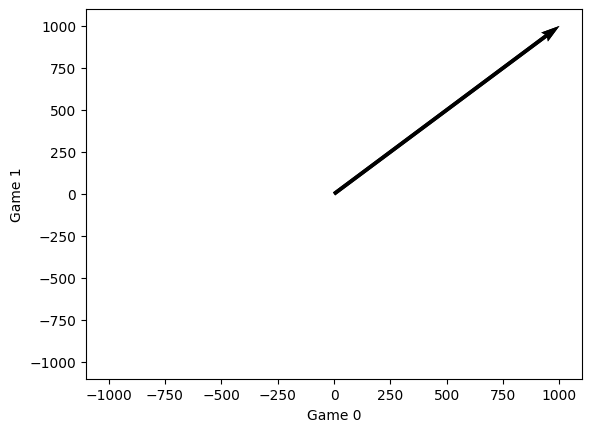

In [10]:
def plot_vectors(vectors, xlim=1100, ylim=1100):
    X, Y, U, V = zip(*vectors)
    plt.figure()
    ax = plt.gca()
    ax.quiver(X, Y, U, V, angles='xy', scale_units='xy', scale=1)
    ax.set_xlim([-xlim, xlim])
    ax.set_ylim([-ylim, ylim])
    ax.set_xlabel('Game 0')
    ax.set_ylabel('Game 1')
    plt.draw()
    plt.show()

    
vectors_1 = np.array([[0, 0, 1000, 1000], [0, 0, 1000, 1000]])
plot_vectors(vectors_1)

From the representation, we understand that the users are **indifferent between both games**, i.e., like them equally, as illustrated by the 45º line.

In the similarity metric we choose, **the similarity between these vectors must be high**.

### 2.4.2 Does scale matter?

Now imagine two players that play the same games, but one player (player A) plays more hours. This is the ratings matrix:

In [11]:
example_2 = pd.DataFrame.from_dict({'A': [1000, 1000], 'B': [500, 500]})
example_2

,A,B
0,1000,500
1,1000,500


These vectors are **collinear** and **have the same direction**, but have **different magnitudes**.

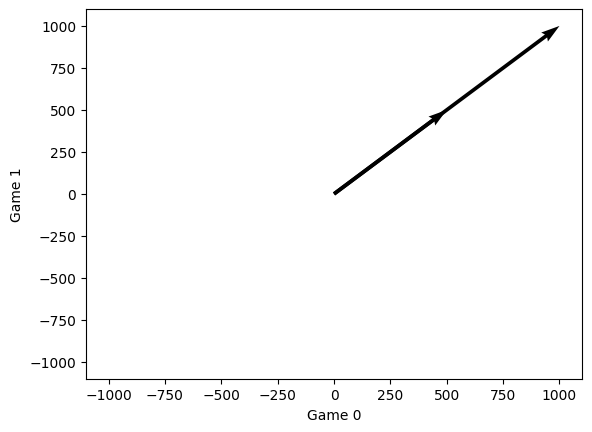

In [12]:
vectors_2 = np.array([[0, 0, 1000, 1000], [0, 0, 500, 500]])
plot_vectors(vectors_2)

We are interested in relative preferences, i.e., how items are valued relative to each other, and thus **consider only the direction and orientation** and **ignore the differences in vector magnitude**. 

Henceforth, in our chosen metric, **the similarity between the vectors should be high still** (and exactly as high as in the last example). 

Note that metrics that consider the magnitude of the vectors, such as the [dot product](https://en.wikipedia.org/wiki/Dot_product), violate this principle.

### 2.4.3 Users with exclusive ratings

Now, take the case in which users play exclusively different games for the same amount of time.

In [13]:
example_3 = pd.DataFrame.from_dict({'A': [1000, 0], 'B': [0, 1000]})
example_3

,A,B
0,1000,0
1,0,1000


These are users with completely different tastes. Again, **we project the users into the space of the games**.

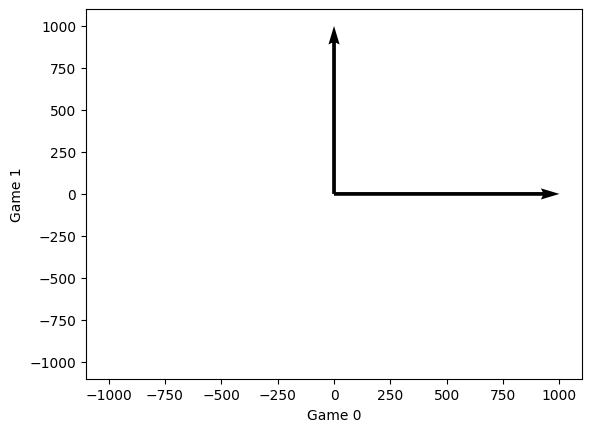

In [14]:
vectors_3 = np.array([[0, 0, 1000, 0], [0, 0, 0, 1000]])
plot_vectors(vectors_3)

**The respective user vectors are orthogonal in space** - there is no similarity.

It means that the users have nothing in common, so **our similarity metric should give zero** in this case.

### 2.4.4 What about opposite ratings?
Consider now that the company asks for __feedback__ (e.g. a like/dislike button) from the players. This is a new situation because unlike the hours played, the feedback can be __positive (1)__ or __negative (-1)__. How should a similarity metric reflect this? This is our new rating matrix with the feedback of players A and B from the like/dislike button.

In [15]:
example_4 = pd.DataFrame.from_dict({'A': [1, 0], 'B': [-1, 0]})
example_4

,A,B
0,1,-1
1,0,0


**Players A and B are inversely affected by game 0**, whereas player A likes it (positive feedback), player B doesn't (negative feedback).

What can we conclude by inspecting the user vectors?

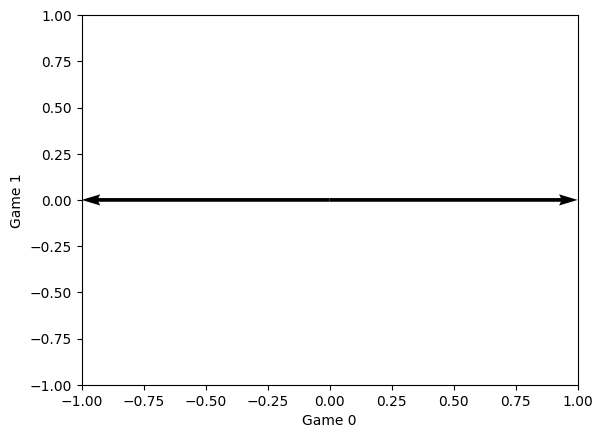

In [16]:
vectors_4 = np.array([[0, 0, 1, 0], [0, 0, -1, 0]])
plot_vectors(vectors_4, 1, 1)

The user vectors, in this case, **are collinear but have opposite directions** and a negative similarity (i.e., **they are the opposite**). Thus, the similarity metric of our choice should return a negative value in this case.

We have already used such a similarity metric in the NLP specialization. Remember **cosine similarity**?.

### 2.4.5 Cosine similarity

The cosine similarity, which **measures the difference in the direction of two vectors by calculating the cosine of the angle between them**, fits our problem:

$$sim(u, v) = cos(\theta) = \frac{u \cdot v}{||u||||v||}$$

Where $u$ and $v$ **represent 2 vectors of ratings from a pair of users** - two rows of the ratings matrix. In the same way, we can calculate the similarity between two item vectors - two columns of the ratings matrix.

The cosine distance is **the normalized dot product** (and therefore unaffected by the magnitude of the vectors) and the resulting similarity ranges from -1 to 1:
* −1 meaning that the two vectors are pointing in opposite directions (example 4)
* 1 meaning that the two vectors are pointing in the same direction (examples 1 and 2)
* 0 indicating orthogonality (example 3)
* In-between values indicate intermediate similarity.

Sometimes, you will find the concept of **cosine distance** which is just the opposite of the cosine similarity:

$$dist(u, v) = 1- sim(u, v)$$

The higher the cosine distance, the less similar are the vectors.

Let's make a function to calculate cosine similarity for a pair of vectors and calculate it for the four examples from above:

In [17]:
def similarity(u, v):
    return round(np.dot(u, v) / (norm(u) * norm(v)), 2)


similarity(example_1.A, example_1.B)

1.0

In [18]:
similarity(example_2.A, example_2.B)

1.0

In [19]:
similarity(example_3.A, example_3.B)

0.0

In [20]:
similarity(example_4.A, example_4.B)

-1.0

See? It behaves exactly as we wanted.

Implementation time: the `cosine_similarity` from `sklearn.metrics.pairwise` computes the cosine similarity between samples in $A$ and $B$ ([docs](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html)):

$$sim(A, B) = \frac{A \cdot B}{||A||||B||}$$ 

$A$ and $B$ can be vectors or matrices.  The **result will be a matrix of shape (n_samples_A,n_samples_B)**. If the inputs are sparse, we can opt to obtain a dense matrix with the `dense_output` parameter.

Our use case will be to compute similarity between a set of user vectors (rows of the ratings matrix) or between a set of item vectors (columns of the ratings matrix). For this, we call the function with just one parameter - the ratings matrix (or it's subset) to calculate user similarities or the transposed ratings matrix to calculate item similarities.

Doing this, we can compute the cosine similarity between all samples at once, in a vectorized and efficient way.

### 2.4.6 Computing similarities between users

We calculate the user similarity matrix $S_u$ containing the cosine similarity between all pairs of users $(u, v) \in U \times U$:

$$S_U = \frac{R \cdot R^T}{||R||||R^T||}$$

$R$ and its transpose $R^T$ are $U \times I$ and $I \times U$ matrices, respectively. $S_u$ is a $U \times U$ matrix:

$$S_U = \begin{bmatrix}1 & cos(u_1, v_2) & \dots & cos(u_1, v_m) \\ cos(u_2, v_1) & 1 & \dots & cos(u_2, v_m) \\ \dots  & \dots & 1 & \dots \\ cos(u_m, v_1) & cos(u_m, v_2) & \dots & 1\end{bmatrix}$$

The result is a symmetric matrix, a square matrix **with repeated entries above and below the main diagonal**. For storage purposes, you could save disk space by converting the symmetric matrix into a lower or upper triangular matrix (all entries above or below the main diagonal are zero, respectively).

In [21]:
user_similarities = cosine_similarity(R, dense_output=False)

### 2.4.7 Computing similarities between items

We calculate the items similarity matrix $S_i$ containing the cosine similarity between all pairs of items $(i, j) \in I \times I$:

$$S_I = \frac{R^T \cdot R}{||R^T||||R||}$$

$R^T$ and $R$ are $I \times U$ and $U \times I$ matrices, respectively. $S_I$ is a $I \times I$ matrix:

$$S_I = \begin{bmatrix}1 & cos(i_1, j_2) & \dots & cos(i_1, j_n) \\ cos(i_2, j_1) & 1 & \dots & cos(i_2, j_n) \\ \dots  & \dots & \dots & \dots \\ cos(i_n, j_1) & cos(i_n, j_2) & \dots & 1\end{bmatrix}$$

In [22]:
item_similarities = cosine_similarity(R.T, dense_output=False)

# 3. Making predictions

## 3.1 Based on user similarities

For the sake of simplicity, for this prediction we're going to use all the users that rated the item $i$, $N_i(u)$, instead of just the $k$ most similar neighbors. We will calculate the weighted average of the ratings of item $i$, using the user similarities as weights:

$$\hat{r}_{ui} = \frac{\sum_{v \in N_i(u)} sim(u, v)  \cdot r_{vi}}{\sum_{v \in N_i(u)} |sim(u, v)|}$$

In the function below, we will do the calculations for the whole community at once, using matrices.

In [23]:
def make_user_predictions(S, R):
    """
    Parameters:
    S: matrix of user similarities
    R: ratings matrix
    
    Returns:
    preds: csr matrix of predictions
    """
    # Calculate the numerator of the sum:
    weighted_sum = np.dot(S, R)
    
    # Note that in the denominator we are only interested in the
    # neighbors of user U that have rated item I. Those are 
    # given to us by the dot product between S and R_boolean.
    # It may be useful for you to draw the matrixes and 
    # visualize why this happens!
    
    R_boolean = R.copy() 
    R_boolean[R_boolean > 0] = 1 # take the existing ratings (we assume positive ratings)
    preds = np.divide(weighted_sum, np.dot(S, R_boolean)) 
    
    # Exclude previously rated items.
    preds[R.nonzero()] = 0
    
    return csr_matrix(preds)
 

user_preds = make_user_predictions(user_similarities, R)

Let's see how many ratings we were able to predict:

In [24]:
def sparsity(matrix):
    return 1 - matrix.nnz / (matrix.shape[0] * matrix.shape[1])


sparsity(user_preds)

0.0020161564563957457

Above, we use `.nnz` to return the count of non-zero values of the matrix ([docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.nnz.html)). The sparsity score gives us **the percentage of ratings that we couldn't predict**.

We are missing only 0.2% of predictions! This is very very little which means that we were able to make predictions for almost every user!

This happens because almost every user has neighbours. But in real life, it will most likely not happen. You may have a lot of users without neighbours.

In that case, you will probably not be able to predict a significant % of the ratings.

That's what we call the **the cold-start problem**. Notably, you won't be able to make predictions **for users that don't have items in common with other users**. In that case, the neighborhood of these users is empty, $N(u) = \emptyset$.

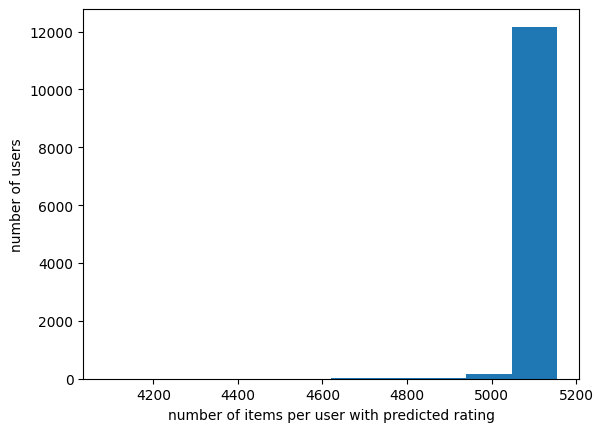

In [25]:
plt.hist(user_preds.getnnz(axis=1))
plt.xlabel('number of items per user with predicted rating')
plt.ylabel('number of users');

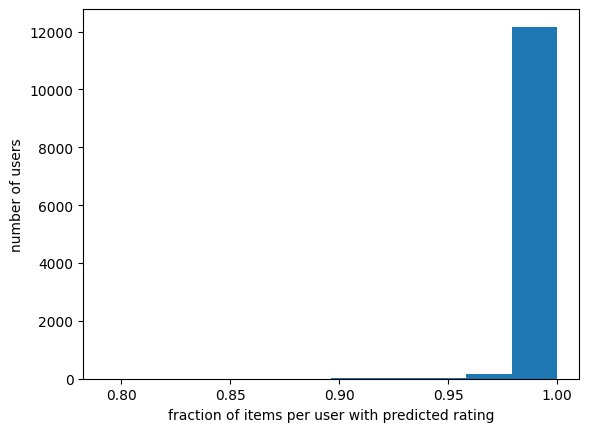

In [26]:
# same plot but with fractions instead of absolute counts
plt.hist(user_preds.getnnz(axis=1) / user_preds.shape[1])
plt.xlabel('fraction of items per user with predicted rating')
plt.ylabel('number of users');

From the plot above, we understand that **most users have a significant number of predicted item ratings**.

Let's plot the number of neighbors per user:

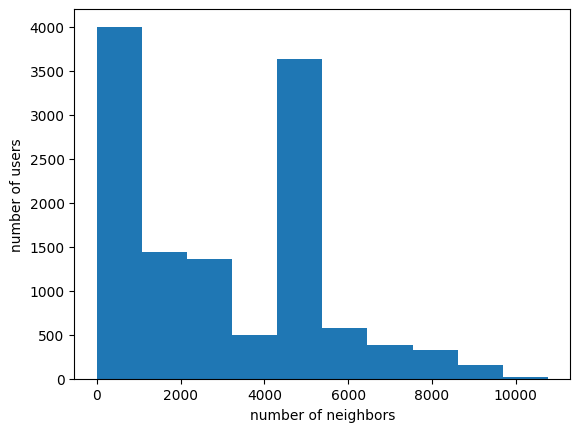

In [27]:
# The -1 is because the user_similarities matrix has 1 on the main diagonal
# which represents self-similarity that we don't want to consider
user_total_neighbors = user_similarities.getnnz(axis=1) - 1
plt.hist(user_total_neighbors)
plt.xlabel('number of neighbors')
plt.ylabel('number of users');

From the plot above, we also realize that **a significant amount of users doesn't have many neighbors** (i.e., users with at least one item in common). The plot below shows the above zoomed in on the users with few neighbors.

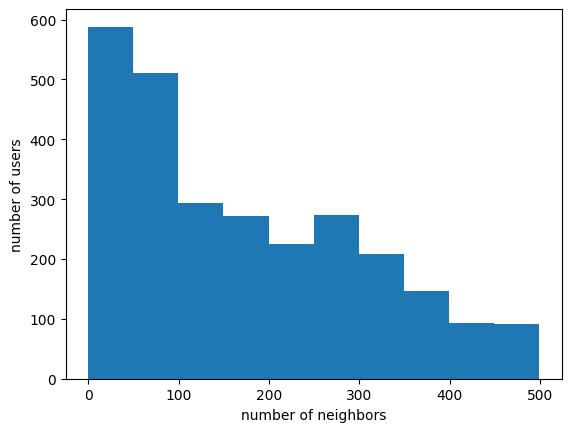

In [28]:
plt.hist(user_total_neighbors[user_total_neighbors < 500])
plt.xlabel('number of neighbors')
plt.ylabel('number of users');

In [29]:
user_total_neighbors[user_total_neighbors < 500].shape[0]

2701

There are 2701 users with **less than 500 neighbors**.

In [30]:
(user_total_neighbors == 0).sum()

19

**But only 19 users don't have neighbors, which is close to none!**

For as long as one neighbor has **rated the item whose rating we are predicting**, we can make a prediction. Hence, **the very very low sparsity score of the predictions matrix**. But **we can't assure that the prediction is any good**. 

Imagine the extreme case in which a user has a single neighbor and that neighbor is not similar at all: what will we predict? Well, we'll predict that the user won't like anything that the neighbor has bought (these items will have a bad predicted rating), but we don't know how to recommend anything else, because all the other items will have a neutral predicted rating!

Also, there's the trade-off: if we limit the predictions to users with over **a minimum threshold of neighbors**, possibly even accounting for minimum similarity, **the sparsity of the predictions matrix increases**, and we'll need to address it, somehow. (Non-personalized recommendations, perhaps.)

The cold-start problem is a **major limitation of collaborative-filtering** that we will explore shortly.

## 3.2 Based on item similarities

Analogously, we can use $S_i$ to make predictions based on all available neighbors, $N_u(i)$:

$$\hat{r}_{ui} = \frac{\sum_{j \in N_u(i)} sim(i, j)  \cdot r_{uj}}{\sum_{j \in N_u(i)} |sim(i, j)|}$$

Again, the existence of a neighborhood of item $i$ for user $u$, $N_u(i)$, depends on having **at least one other item $j \in I$ also rated by $u$**. 

In [31]:
def make_item_predictions(S, R):
    """
    Parameters:
    S: matrix of user similarities
    R: ratings matrix
    
    Returns:
    preds: csr matrix of predictions
    """
    
    # this is the analogous function for item predictions
    weighted_sum = np.dot(R, S)
        
    R_boolean = R.copy() 
    R_boolean[R_boolean > 0] = 1 
    preds = np.divide(weighted_sum, np.dot(R_boolean, S)) 
    
    # Exclude previously rated items.
    preds[R.nonzero()] = 0
    
    return csr_matrix(preds)

 
item_preds = make_item_predictions(item_similarities, R)
sparsity(item_preds)

0.0020161564563957457

Again, we compute the **sparsity score**, which we realize to be the same. You can try it for yourself, **the histograms above for the matrix of predictions also stay the same**.

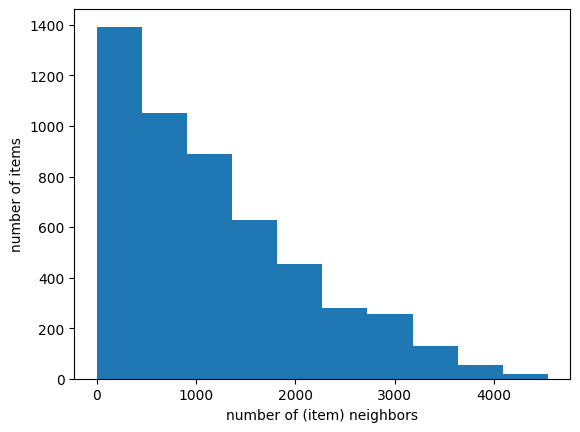

In [32]:
plt.hist(item_similarities.getnnz(axis=1))
plt.xlabel('number of (item) neighbors')
plt.ylabel('number of items');

The histogram above also shows us that **the distribution of the number of neighbors is quite skewed to the left**, i.e., there are still small neighborhoods.

So, item-based recommendations **don't help us in dealing with the cold-start problem**.

Item-based recommendations, empirically, are said to be **more stable than user preferences**. It means that we don't have to recompute them as often.
As an intuition for this, you can think that we usually have more interactions at the product level than at the user level: while an item will be rated/bought thousands of times, a user will only rate/buy maybe hundreds of products. So the item similarities will tend to be more reliable and change less when new interactions are added.

# 4. Filtering

Now that we have the predictions, the last step is to **filter the items** to recommend the most promising ones.

## 4.1 Best-item

A typical approach is to recommend the best item, i.e., **the item with the highest predicted rating**.

To do this, we can use `argsort` ([docs](https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html)).

In [33]:
def get_best_item(pred):
    return np.negative(pred).toarray().argsort()[:, :1]


get_best_item(user_preds)

array([[1606],
       [3045],
       [3045],
       ...,
       [2398],
       [1761],
       [1761]])

In [34]:
get_best_item(item_preds)

array([[ 687],
       [1988],
       [3421],
       ...,
       [2577],
       [3761],
       [2577]])

The result, in both cases, is **a column-vector containing the best items for each user**.

Finally, we can use the `video_games` table to retrieve the name of the game.

In [35]:
video_games.loc[1606]

VideoGameName    FIFA Manager 09
Name: 1606, dtype: object

In [36]:
video_games.loc[687]

VideoGameName    Bus-Simulator 2012
Name: 687, dtype: object

## 4.2 Top-N

Perhaps the most typical task, however, is to recommend a top-$N$ list to the user, i.e., **the $N$ items with the best ratings**.

In [37]:
def get_top_n(pred, n):
    pred_ = np.negative(pred).toarray()
    return pred_.argsort()[:, :n]


get_top_n(user_preds, 5)

array([[1606, 1762, 5019, 2392, 3045],
       [3045, 1606, 1762, 5019, 1763],
       [3045, 1761, 1760, 1762, 1606],
       ...,
       [2398, 1559, 1765, 4343, 4663],
       [1761, 1762, 1765, 1795, 3834],
       [1761, 1762, 1765, 1795, 3834]])

In [38]:
get_top_n(item_preds, 5)

array([[ 687, 3421, 1007,  504, 4457],
       [1988, 4079, 3958,  108, 2527],
       [3421, 4954, 4951, 4953, 4685],
       ...,
       [2577, 3118, 3119, 3121, 3122],
       [3761, 2992, 4410,  641, 1283],
       [2577, 3312, 3300, 3299, 3298]])

Again, we can use `video_games` as a lookup table.

In [39]:
video_games.loc[3045]

VideoGameName    Out of the Park Baseball 16
Name: 3045, dtype: object

In [40]:
video_games.loc[1988]

VideoGameName    Gravity Core - Braintwisting Space Odyssey
Name: 1988, dtype: object

In [41]:
video_games.loc[1761]

VideoGameName    Football Manager 2011
Name: 1761, dtype: object

In [42]:
video_games.loc[3421]

VideoGameName    Radial Impact
Name: 3421, dtype: object

Back to the **cold-start problem** now.

# 5. Cold-start problem

The cold-start problem means that **there is a minimum critical mass of users and items connected through ratings that are required** for collaborative filtering to work.

Intuitively, this makes much sense.

**The more ratings, the better and more complete the similarities** and **the more accurate the predictions**, mainly when many users are rating many items, i.e., a big community.

Also, even in significantly connected communities, **new users always face the cold-start problem**, as either:
* There is not enough information to identify similar users, because the neighborhood $N(u)$ is nonexistent at first and then small.
* There are not enough ratings from the user to compute predictions based on item similarities.

The same applies to **new items**.

Hence, there is the need for techniques that are more robust to this problem, if we want to have (1) **more complete** and (2) **better predictions**.